# Optimización del modelo Naive Bayes 

Algunas de las estrategias que mejor funcionan para mejorar las métricas del algoritmo Naive-Bayes son las siguientes: 
- Evaluación datos desbalanceados
- Revisar la correlación entre variables: cuando dos variables presentan una fuerte correlación el algoritmo las tendrá en cuenta, duplicando su importancia y por lo tanto empeorando el algoritmo. Es importante eliminar variables con elevada correlación. 


In [73]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# pycaret
from pycaret.classification import *

# datos desbalanceados 
import imblearn
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import cohen_kappa_score

In [74]:
path ='LiverPatient.csv'

all_data =pd.read_csv(path, header =0)
# Add column names 
all_data.columns= ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'AG', 'Status']

# Transform Gender to categorical 
all_data['Gender'].replace('Female',0 ,inplace=True)
all_data['Gender'].replace('Male',1,inplace=True)

all_data.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,AG,Status
0,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
1,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
2,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
3,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1
4,46,1,1.8,0.7,208,19,14,7.6,4.4,1.30,1


## 2. Pre-procesamiento 
Se transforma la variable 'Gender' a categórica. 

In [75]:
# Drop missing values 
all_data = all_data.dropna()

In [76]:
data = np.array(all_data['Status']).copy()
data[data == 1] = 0
data[data == 2] = 1
dataset = all_data
dataset.drop('Status', inplace=True, axis=1)

dataset['Status'] = data.tolist()

dataset.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,AG,Status
0,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,0
1,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,0
2,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,0
3,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,0
4,46,1,1.8,0.7,208,19,14,7.6,4.4,1.30,0


## 2.1. Datos desbalanceados

Como se ha visto en el EDA, la variable 'Status' está fuertemente desbalanceada, así que se ha decidido evaluar algunas estrategias que ayudan a minimizar este problema: 
- Random oversampling: se generan datos aleatoriamente para que caso con menos datos iguale en número al que tiene más. 
- Random undersampling: de manera contraria, se reduce el dataset de manera aleatoria hasta que se igualan por abajo. 
- NearMiss: es otra técnica de undersampling que igualará las dos categorías
- SMOTE: utiliza k-vecinos mas cercanos para generar nuevos datos e igualar las categorías en el número más alto

In [77]:
# random oversampling 
oversample = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = oversample.fit_resample(dataset.iloc[:,0:10], dataset['Status'])
data_oversampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
data_oversampled.columns = dataset.columns
data_oversampled['Status'].value_counts()

0    413
1    413
Name: Status, dtype: int64

In [78]:
# Random undersampling
undersample = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = undersample.fit_resample(all_data.iloc[:,0:10], all_data['Status'])
data_undersampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
data_undersampled.columns = all_data.columns
data_undersampled['Status'].value_counts()

0    165
1    165
Name: Status, dtype: int64

In [79]:
# NearMiss
nm = NearMiss()

x_nm, y_nm = nm.fit_resample(all_data.iloc[:,0:10], all_data['Status'])

data_nm = pd.concat([pd.DataFrame(x_nm), pd.DataFrame(y_nm)], axis=1)
data_nm.columns = all_data.columns
data_nm['Status'].value_counts()

0    165
1    165
Name: Status, dtype: int64

In [80]:
#SMOTE
sm = SMOTE()
x_sm, y_sm = sm.fit_resample(all_data.iloc[:,0:10], all_data['Status'])
data_sm = pd.concat([pd.DataFrame(x_sm), pd.DataFrame(y_sm)], axis=1)
data_sm.columns = all_data.columns
data_sm['Status'].value_counts()

0    413
1    413
Name: Status, dtype: int64

In [81]:
# modificando esto se prueban las distinas aproximaciones
technique = data_oversampled
# dataset sin la variable objetivo
data_st = technique.drop(['Status'], axis=1)


#### Evaluación del modelo

In [83]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 2)

In [82]:
x = technique.drop(["Status"], axis = 1)
y = technique.Status.values

In [84]:
nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)


In [85]:
# Calculating the accuracy of classifier
print(f"Accuracy of the classifier is: ",nb.score(x_test, y_test))


Accuracy of the classifier is:  0.6593406593406593


In [86]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.34      0.49       130
           1       0.61      0.95      0.75       143

    accuracy                           0.66       273
   macro avg       0.74      0.64      0.62       273
weighted avg       0.73      0.66      0.62       273



<AxesSubplot:>

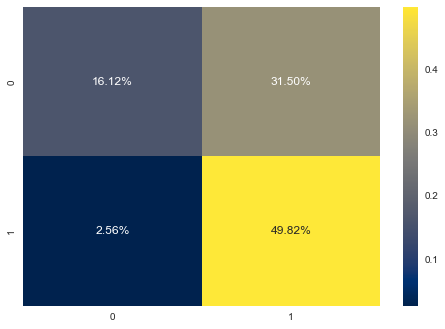

In [87]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='cividis')

In [88]:
kappa = cohen_kappa_score(y_test, y_pred)
# Printing kappa
print(f"Kappa for our classifier is: {kappa}")

Kappa for our classifier is: 0.2977346278317151


## 2.2. Multicolinealidad


In [89]:
new_data=dataset.copy()

In [90]:
# eliminar una de las variables de las parejas 
new_data = dataset.drop('TB', axis=1)
# eliminar una de las variables de las parejas 
new_data = new_data.drop('Sgot', axis=1)

In [91]:
x = new_data.drop(["Status"], axis = 1)
y = new_data.Status.values

In [92]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 2)

In [93]:
nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)


In [94]:
# Calculating the accuracy of classifier
print(f"Accuracy of the classifier is: ",nb.score(x_test, y_test))


Accuracy of the classifier is:  0.5497382198952879


In [95]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.41      0.57       142
           1       0.36      0.96      0.52        49

    accuracy                           0.55       191
   macro avg       0.66      0.68      0.55       191
weighted avg       0.81      0.55      0.56       191



<AxesSubplot:>

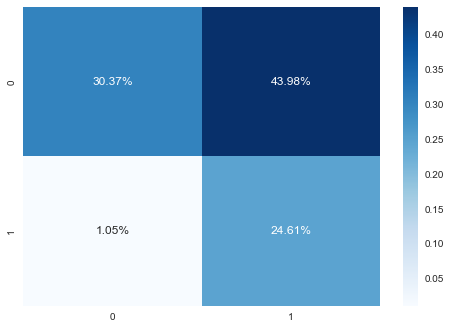

In [96]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

In [97]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test, y_pred)
# Printing kappa
print(f"Kappa for our classifier is: {kappa}")

Kappa for our classifier is: 0.23748955528734572
